In [1]:
from google.colab import userdata
import json

# Get the Kaggle credentials from Colab's userdata
username = userdata.get("KAGGLE_USER")
key = userdata.get("KAGGLE_KEY")

# Echo the credentials into the kaggle.json file
!mkdir -p ~/.kaggle
!echo '{{"username":"{username}","key":"{key}"}}' > ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c image-processing-house-recognition
!unzip /content/image-processing-house-recognition.zip -d /content/house-recognition
!rm -rf /content/image-processing-house-recognition.zip

Archive:  /content/image-processing-house-recognition.zip
  inflating: /content/house-recognition/sample_submission.csv  
  inflating: /content/house-recognition/test/test/00162f19.jpg  
  inflating: /content/house-recognition/test/test/004c4789.jpg  
  inflating: /content/house-recognition/test/test/0059b42f.jpg  
  inflating: /content/house-recognition/test/test/005f930c.jpg  
  inflating: /content/house-recognition/test/test/009095e8.jpg  
  inflating: /content/house-recognition/test/test/00a98706.jpg  
  inflating: /content/house-recognition/test/test/00da9dd7.jpg  
  inflating: /content/house-recognition/test/test/00e2bfe0.jpg  
  inflating: /content/house-recognition/test/test/00eac2a3.jpg  
  inflating: /content/house-recognition/test/test/01265567.jpg  
  inflating: /content/house-recognition/test/test/0188f57d.jpg  
  inflating: /content/house-recognition/test/test/01945b53.jpg  
  inflating: /content/house-recognition/test/test/01ccbb76.jpg  
  inflating: /content/house-recog

## Overview

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('/content/house-recognition/train.csv')
df['image_name'] = df['image_name'].apply(lambda x: f'/content/house-recognition/train/train/{x}')
df.head()

,image_name,class
0,/content/house-recognition/train/train/ChokCha...,0
1,/content/house-recognition/train/train/ChokCha...,0
2,/content/house-recognition/train/train/ChokCha...,0
3,/content/house-recognition/train/train/ChokCha...,0
4,/content/house-recognition/train/train/ChokCha...,0


In [5]:
def prepare_dirs(df, base_dir='/content/yolo_data'):
    """
    Prepares directories for YOLO training.
    """

    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    for name, split_df in zip(['train', 'val'], [train_df, val_df]):
      os.makedirs(os.path.join(base_dir, name, '0'), exist_ok = True)
      os.makedirs(os.path.join(base_dir, name, '1'), exist_ok = True)

      for index, row in tqdm(split_df.iterrows()):
          image_path = row['image_name']
          class_label = str(row['class'])

          new_image_path = os.path.join(base_dir, name, class_label, os.path.basename(image_path))

          # copy image
          shutil.copy(image_path, new_image_path)


prepare_dirs(df)

2362it [00:01, 1687.70it/s]
591it [00:00, 1294.59it/s]


## EDA

In [43]:
df['class'].value_counts()

,count
class,
0,1520
1,1433


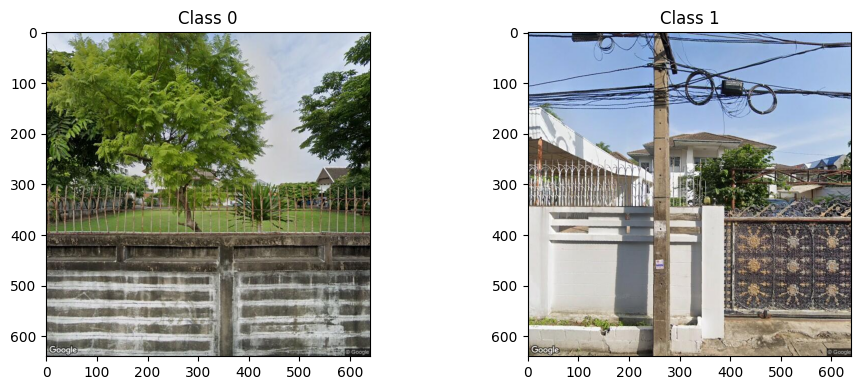

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(plt.imread(df[df['class'] == 0]['image_name'].iloc[0]))
plt.title('Class 0')

plt.subplot(1, 2, 2)
plt.imshow(plt.imread(df[df['class'] == 1]['image_name'].iloc[0]))
plt.title('Class 1')

plt.tight_layout()
plt.show()

## Model Training (YOLO)

In [6]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [34]:
from ultralytics import YOLO

model = YOLO('yolov8n-cls.pt')

results = model.train(data='/content/yolo_data/', epochs=20, imgsz=640, optimizer='AdamW', lr0=5e-4, lrf=1e-3)
model.save('YOLOv8n.pt')

Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/yolo_data/, epochs=20, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /content/yolo_data/train... 2362 images, 0 corrupt: 100%|██████████| 2362/2362 [00:00<?, ?it/s]
val: Scanning /content/yolo_data/val... 591 images, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]


optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/classify/train9
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.65it/s]

                   all      0.904          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 15.64it/s]

                   all      0.934          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 12.34it/s]

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 12.31it/s]

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 18.14it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 14.44it/s]

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 13.07it/s]

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 14.89it/s]

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 14.99it/s]

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20     0.473G      0.146         10        224: 100%|██████████| 148/148 [00:11<00:00, 12.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 13.03it/s]

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20     0.473G     0.1307         10        224: 100%|██████████| 148/148 [00:13<00:00, 10.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:02<00:00,  9.32it/s]

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20     0.473G     0.1163         10        224: 100%|██████████| 148/148 [00:12<00:00, 11.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 14.43it/s]

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20     0.473G     0.1165         10        224: 100%|██████████| 148/148 [00:10<00:00, 13.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 13.10it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20     0.473G     0.1102         10        224: 100%|██████████| 148/148 [00:08<00:00, 16.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 11.62it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20     0.473G     0.1174         10        224: 100%|██████████| 148/148 [00:08<00:00, 16.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 13.93it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20     0.473G    0.09537         10        224: 100%|██████████| 148/148 [00:11<00:00, 13.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 17.01it/s]

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20     0.473G    0.09719         10        224: 100%|██████████| 148/148 [00:11<00:00, 13.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 13.42it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20     0.473G    0.09023         10        224: 100%|██████████| 148/148 [00:09<00:00, 15.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 12.30it/s]

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20     0.473G    0.09347         10        224: 100%|██████████| 148/148 [00:09<00:00, 16.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 15.94it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20     0.473G    0.09757         10        224: 100%|██████████| 148/148 [00:11<00:00, 12.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:01<00:00, 16.22it/s]

                   all      0.956          1



20 epochs completed in 0.074 hours.
Optimizer stripped from runs/classify/train9/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train9/weights/best.pt, 3.0MB

Validating runs/classify/train9/weights/best.pt...
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/yolo_data/train... found 2362 images in 2 classes ✅ 
val: /content/yolo_data/val... found 591 images in 2 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 19.02it/s]


                   all      0.958          1
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train9


## Predictions

In [35]:
test_path = 'house-recognition/test/test/'

test_files = []
test_id = []
for img_path in os.listdir(test_path):
    test_files.append(test_path + img_path)
    test_id.append(img_path.replace('.jpg', ''))

test_df = pd.DataFrame({'image_name': test_files, 'id': test_id})
test_df.head()

,image_name,id
0,house-recognition/test/test/b14a2f05.jpg,b14a2f05
1,house-recognition/test/test/e73d2481.jpg,e73d2481
2,house-recognition/test/test/b1aafe51.jpg,b1aafe51
3,house-recognition/test/test/43ea920e.jpg,43ea920e
4,house-recognition/test/test/9fa1ecd6.jpg,9fa1ecd6


In [36]:
test_pred = []
for img in tqdm(test_df['image_name']):
    results = model(img, verbose=False)
    test_pred.append(results[0].probs.top1)

100%|██████████| 1550/1550 [00:15<00:00, 98.01it/s]


In [37]:
test_df['pred'] = test_pred

submit_dict = {}
for i, row in test_df.iterrows():
    submit_dict[row['id']] = row['pred']
print(submit_dict)

{'b14a2f05': 1, 'e73d2481': 0, 'b1aafe51': 0, '43ea920e': 1, '9fa1ecd6': 1, 'e217629c': 0, '401a6547': 1, '781c193c': 0, '602e6224': 0, '01ee5917': 0, '542bcea5': 0, 'a34abea0': 0, 'c346950c': 1, '7e2030a0': 1, 'e0370240': 1, '7e6cafaa': 1, 'b5a13387': 0, '8ce5fd60': 0, '81f26568': 0, '2e93f5b4': 1, '8df7aec6': 1, '5b7f5128': 1, 'e851fb72': 0, 'd3f19bd2': 1, 'f9984b05': 1, '3107fbe2': 0, '96e72d26': 0, '4d369b4f': 0, '1a2f4b91': 1, 'edee4add': 1, 'aaea811c': 0, 'e89ee007': 1, '5f229900': 0, '5fb482dc': 1, 'de5ae127': 1, '0dfca80c': 1, '31a0aaa9': 1, '6344534a': 0, '397ba7da': 1, 'f9a2a0c6': 1, '4fd38ae5': 1, 'e763db87': 0, '0356ad78': 1, '754a112d': 1, 'b6eee896': 0, 'cf035aba': 1, '21f0bc2e': 1, '14197516': 1, '1aa8fd7f': 1, '8d9eaa59': 0, 'b079fd05': 1, '2f008da4': 0, 'bc12540b': 1, 'ac02f2ab': 1, '899293d5': 1, 'e5bb9358': 1, '73bd7d72': 1, '93246b0d': 0, '4c4ec5c3': 1, '7c56c39f': 1, 'a7402128': 0, 'cbe2448a': 1, 'afeb1f4a': 0, '16fc1242': 1, '3b92b347': 1, '645e314f': 0, '5187b8e7

## Submission

In [38]:
submission = pd.read_csv('/content/house-recognition/sample_submission.csv')
submission['answer'] = submission['id'].map(submit_dict)
submission.head()

,id,answer
0,e4b420b0,0
1,23efa479,0
2,1f0f2402,0
3,8a60480c,0
4,11f20127,0


In [39]:
pd.crosstab(submission['answer'], columns='N')

col_0,N
answer,
0,809
1,741


In [40]:
submission.to_csv('YOLO8n_20epochs_2.csv', index=False)